In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import cubnm_paper
import cubnm

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

Load the data of homogeneous CMA-ES run for an example subject:

In [2]:
cmaes = cubnm_paper.data.load_cmaes(
    sub="912447",
    ses="REST1_LR",
    het_mode="homo",
    seed=1,
    popsize=128,
    n_iter=120,
)

(0.0, 100.0, 100.0, 0.0)

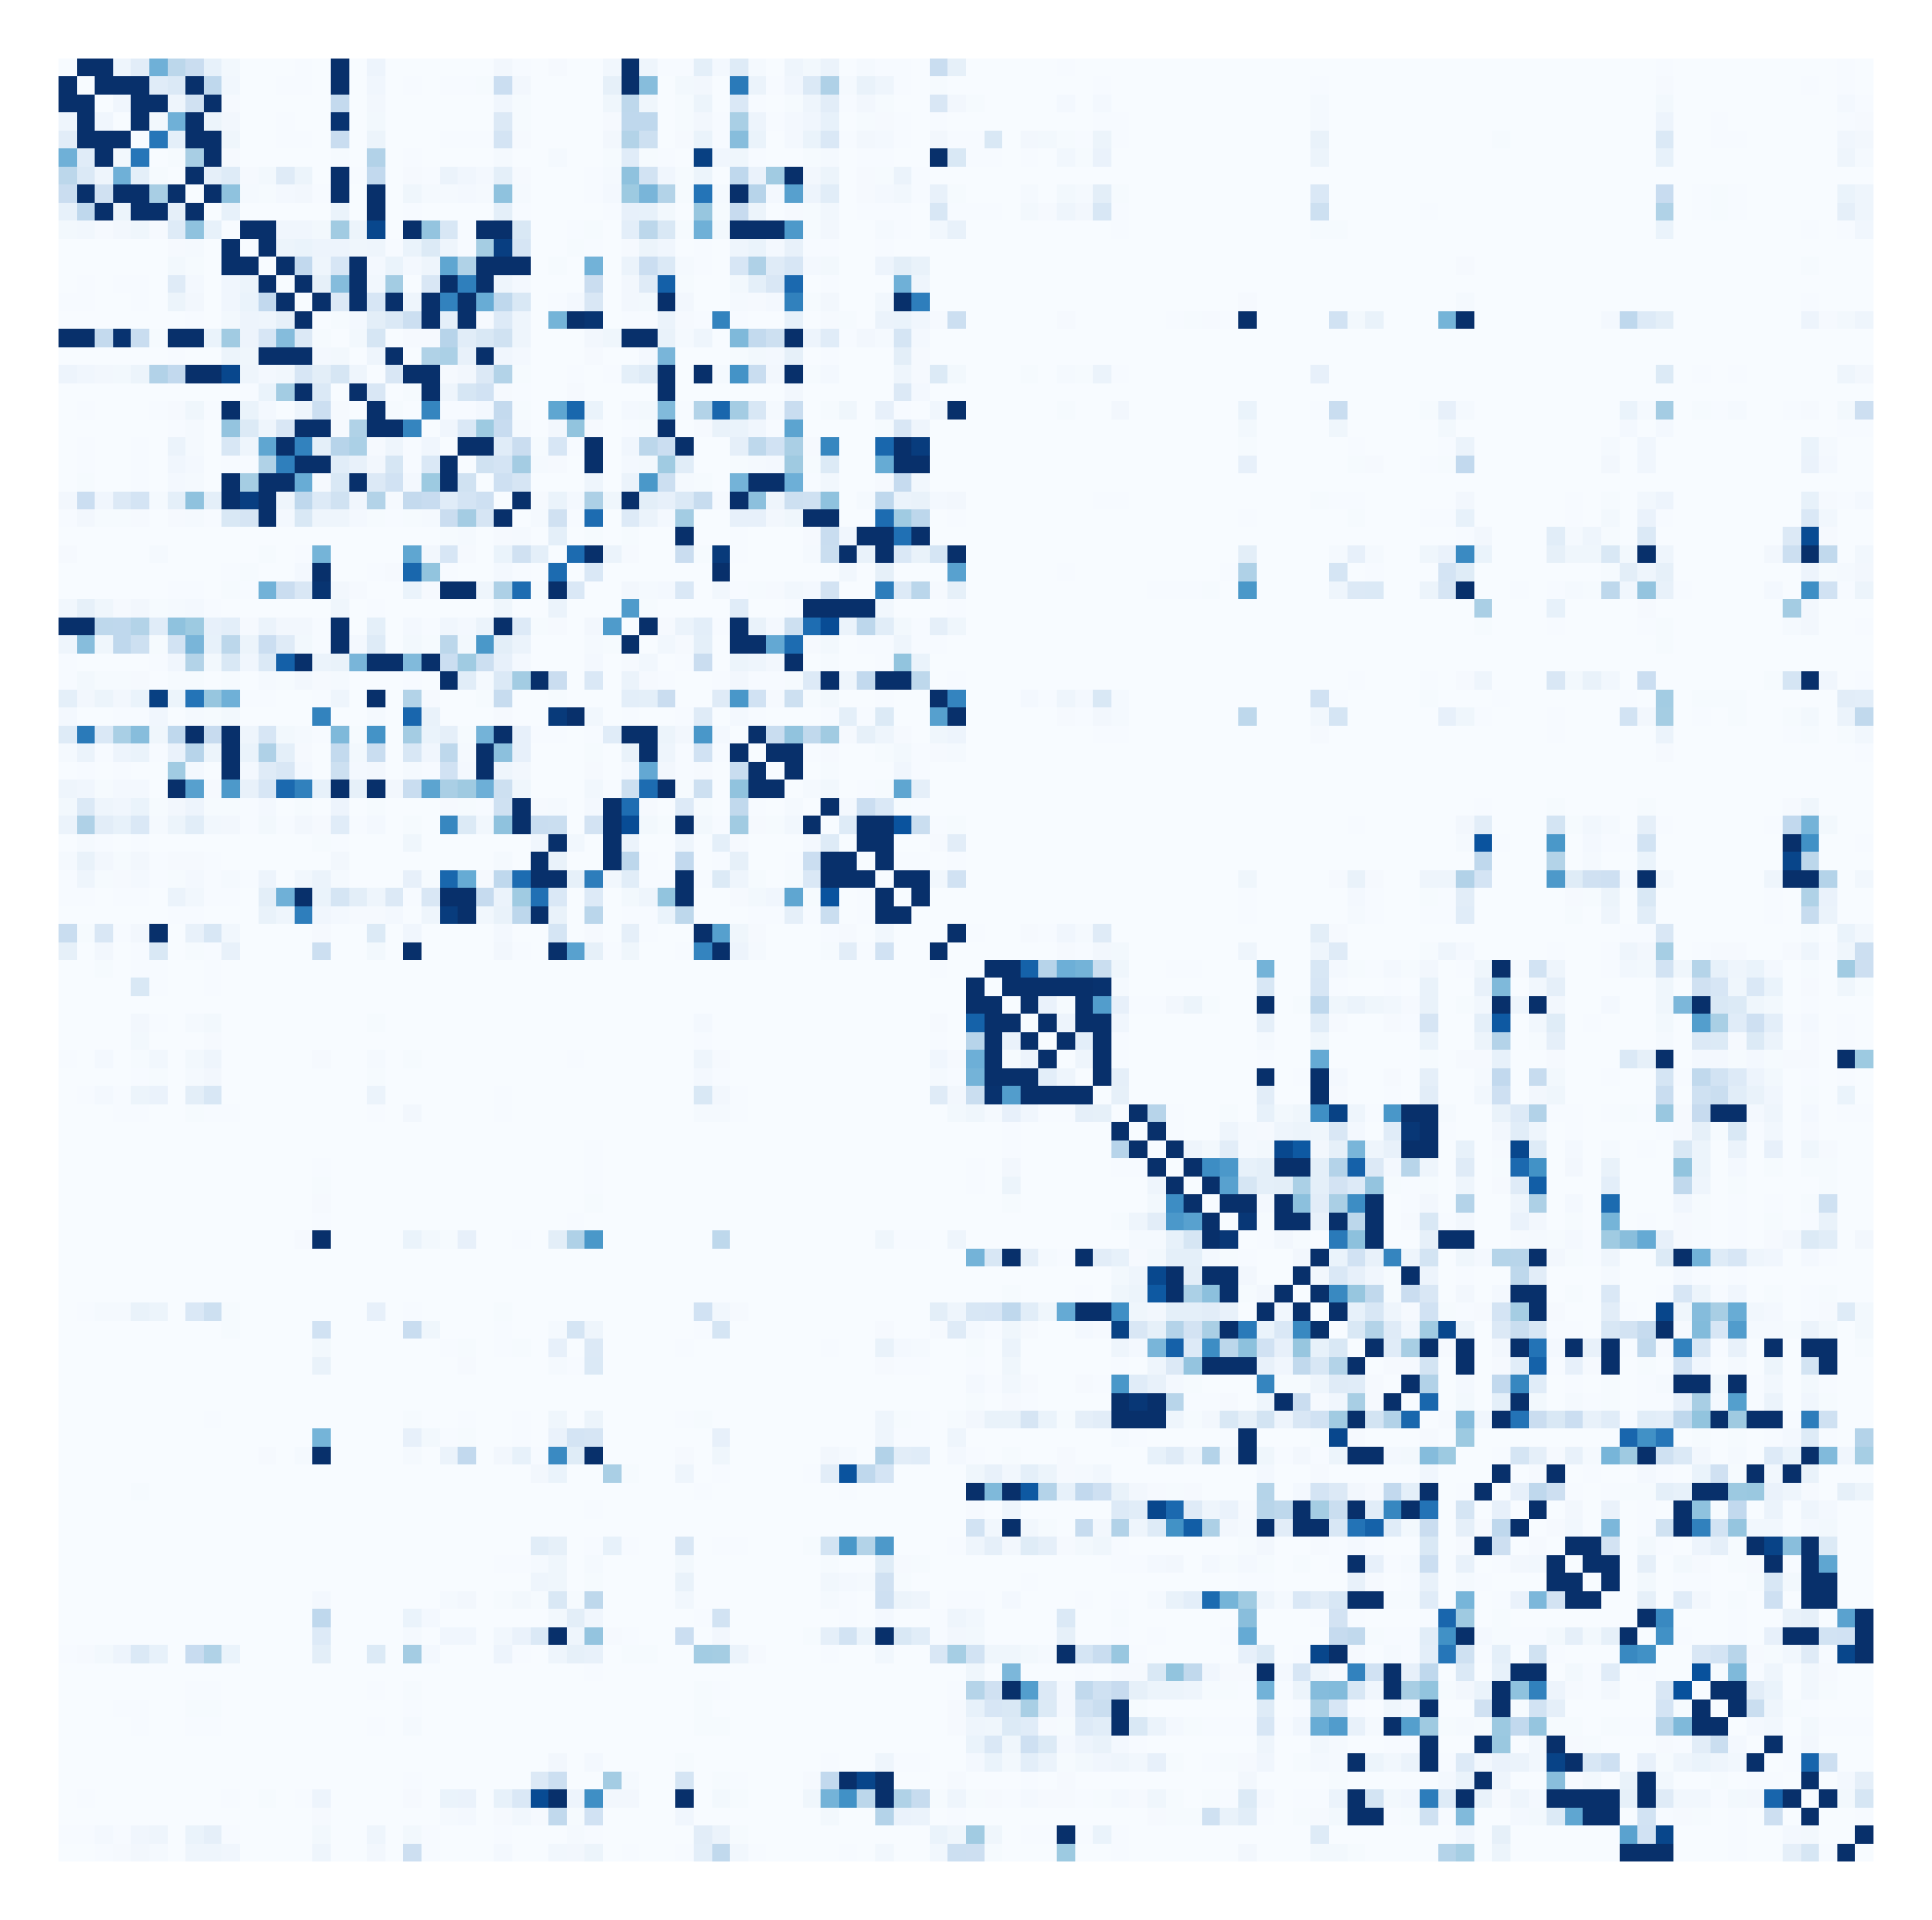

In [3]:
sc = cmaes.problem.sim_group.sc
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    sc, cbar=False, ax=ax, vmin=0, vmax=np.quantile(sc.flatten(), 0.95), cmap="Blues"
)
ax.axis("off")

Select a 4-element sample (with the best particle as the first element):

In [23]:
hist = cmaes.history
sample = pd.concat([
    hist[hist['gen']==1].sort_values('cost').iloc[[0, 30, 60, 100]],
], axis=0)
sample

,index,G,w_p,J_N,cost,+fc_corr,-fcd_ks,+gof,-fic_penalty,gen
11,11,0.826795,0.862125,0.248058,-0.157847,0.298152,-0.127227,0.170925,-0.013077,1
20,20,0.473516,1.142103,0.091459,0.808582,0.122426,-0.931008,-0.808582,0.000000,1
87,87,2.802895,1.278024,0.324273,1.136800,0.239781,-0.912066,-0.672285,-0.464515,1
122,122,5.119405,1.435401,0.258578,1.288736,0.138787,-0.931369,-0.792582,-0.496154,1


Text(-101.47916666666669, 0.5, 'Candidate Sets')

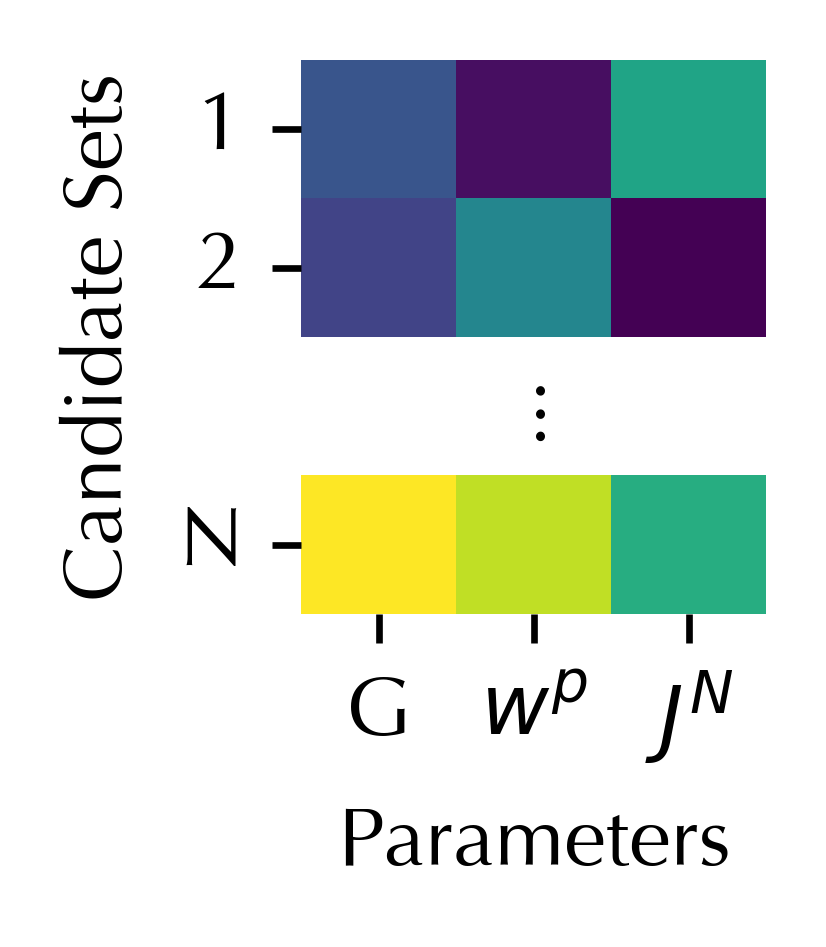

In [24]:
fig, ax = plt.subplots(figsize=(1, 1.2))
plot_data = sample.loc[:, ['G', 'w_p', 'J_N']].apply(scipy.stats.zscore)
plot_data.iloc[-2, :] = np.NaN
sns.heatmap(plot_data, cbar=False, ax=ax, cmap='viridis')
ax.set_xticklabels(['G', r'$w^{p}$', r'$J^{N}$'])
ax.set_yticks(np.array([0, 1, 3])+0.5)
yticklabels = ['1', '2', 'N']
ax.set_yticklabels(yticklabels, rotation=0)
ax.text(
    1.4, 2.5, '...',
    fontsize=10, color='black', rotation='vertical', ha='center', va='center',
)
ax.set_xlabel('Parameters')
ax.set_ylabel('Candidate Sets')

Run the example simulation: best simulation of first generation

In [6]:
if os.path.exists('overview_example_sim_group.pkl.gz'):
    with open('overview_example_sim_group.pkl.gz', 'rb') as f:
        sim_group = pickle.load(f)
else:
    sample_params = sample.iloc[0]
    sim_group = copy.deepcopy(cmaes.problem.sim_group)
    sim_group.N = 1
    sim_group.param_lists.update({
        'G': np.array([sample_params['G']]),
        'w_p': np.full((1, 100), sample_params['w_p']),
        'J_N': np.full((1, 100), sample_params['J_N']),
    })
    sim_group._set_default_params(missing=True)
    sim_group.sim_verbose = True
    sim_group.force_cpu = True
    sim_group.run()
    with open('overview_example_sim_group.pkl.gz', 'wb') as f:
        pickle.dump(sim_group, f)

Initializing CPU session...
Precalculating 60000000 noise elements...
noise will be repeated 30 times (nodes [rows] and timepoints [columns] will be shuffled in each repeat)
took 2.787336 s
Running 1 simulations...
nodes: 100
N_SIMS: 1
N_SCs: 1
BOLD_TR: 720
states_sampling: 720
time_steps: 900000
do_delay: 0
sim_seed: 0
exc_interhemispheric: 1
verbose: 1
progress_interval: 500
bold_remove_s: 30
drop_edges: 1
ext_out: 1
do_fc: 1
do_fcd: 1
states_ts: 0
noise_time_steps: 30000
Thread 0 (of 12) is executing particle 0 [19:38:38]
Simulations completed
Simulations and calculation of FC and FCD took 116.685246 s


Plot simulated and empirical BOLD:

(-60.400000000000006, 1268.4, 0.376085491503776, 3.3868530718331535)

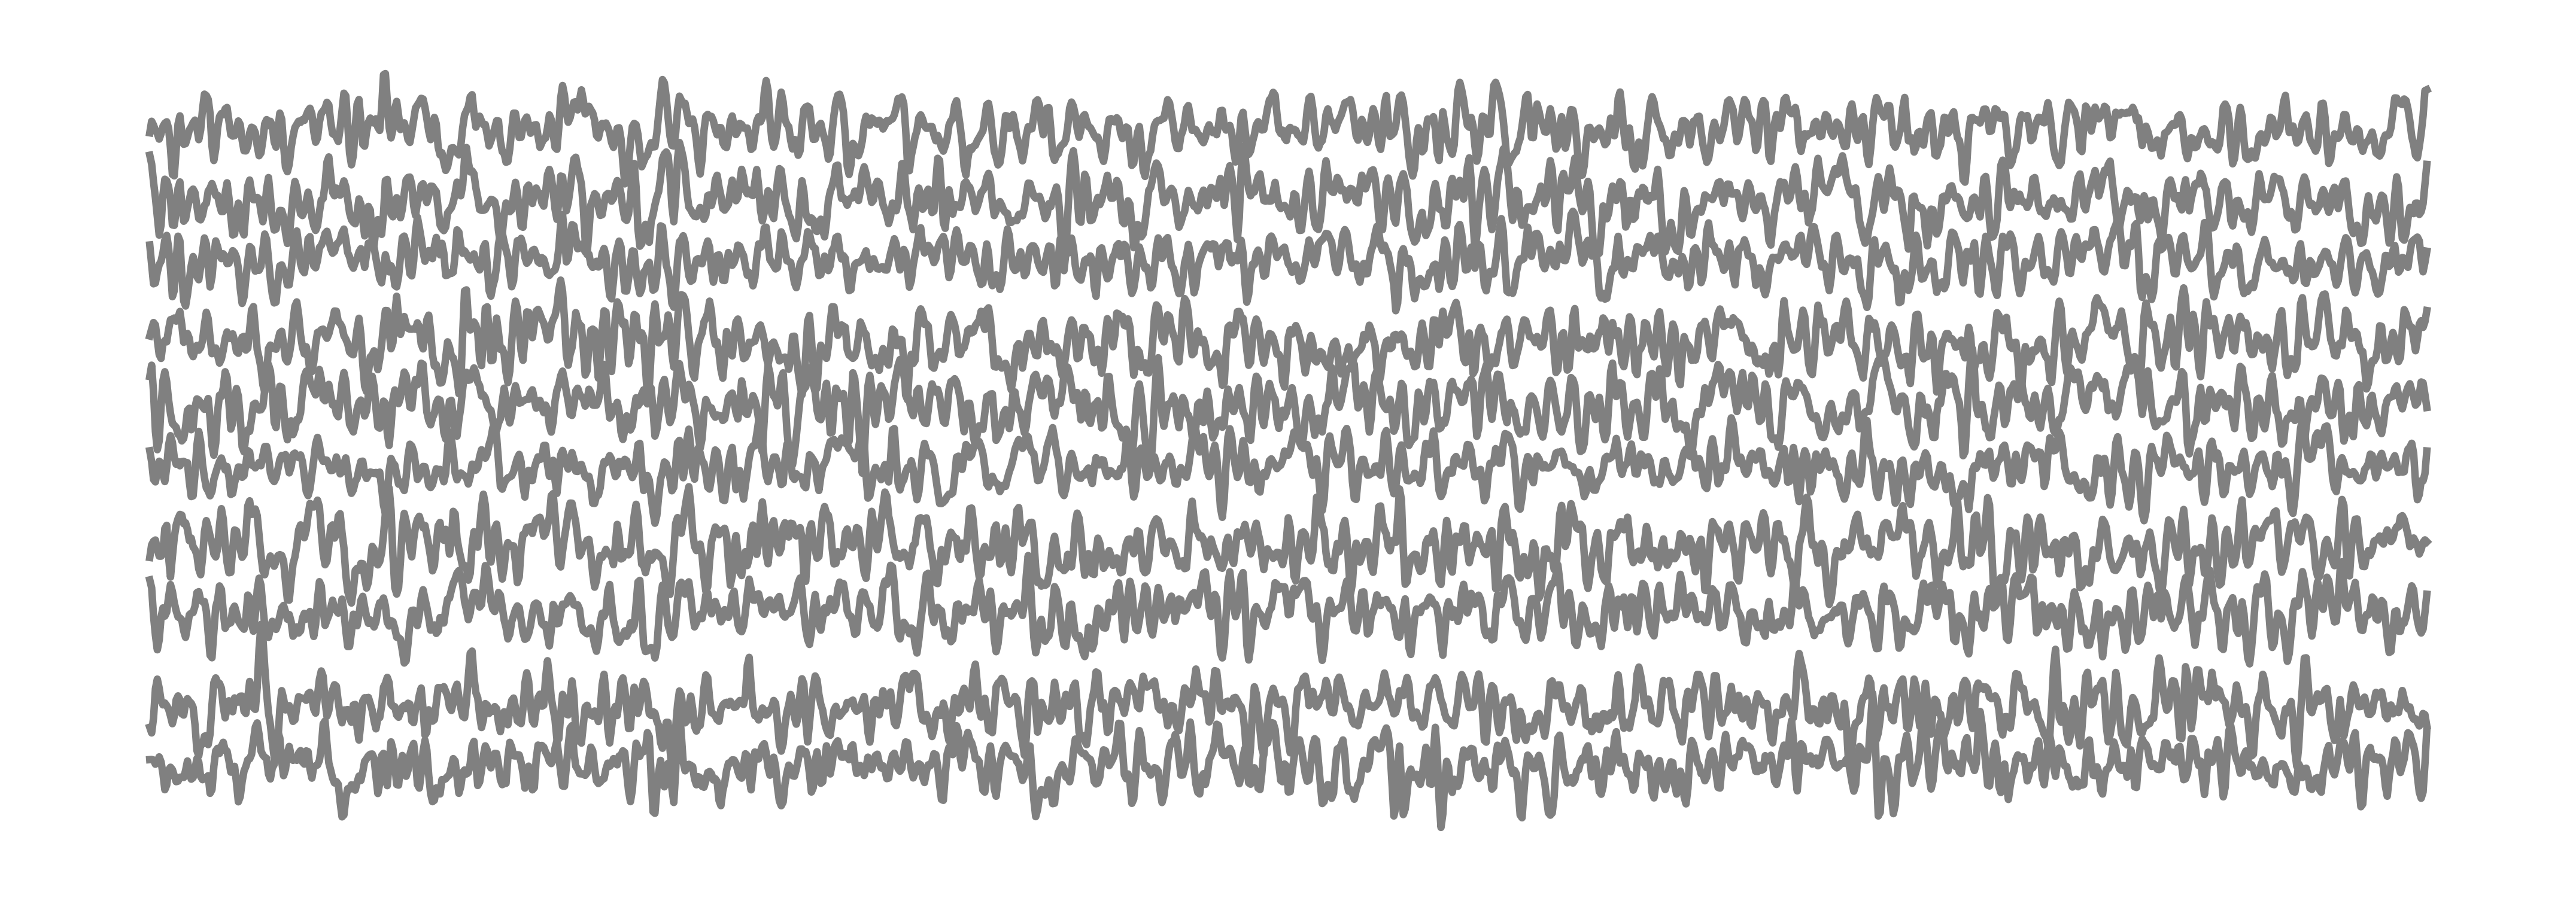

In [7]:
# convert to dataframe and drop the initial 30 seconds
drop_vols = int(sim_group.bold_remove_s // sim_group.TR)
sim_bold = pd.DataFrame(sim_group.sim_bold[0,drop_vols:, :].T)

# plot 10 regions
fig, ax = plt.subplots(figsize=(9, 3))
for i in range(0, 100, 10):
    ax.plot(
        sim_bold.columns,
        0.025 * i + (sim_bold.iloc[i, :] / sim_bold.iloc[i, :].max()),
        color="grey",
    )
ax.axis('off')

(-59.95, 1258.95, -1.8967696597633013, 12.923655698083966)

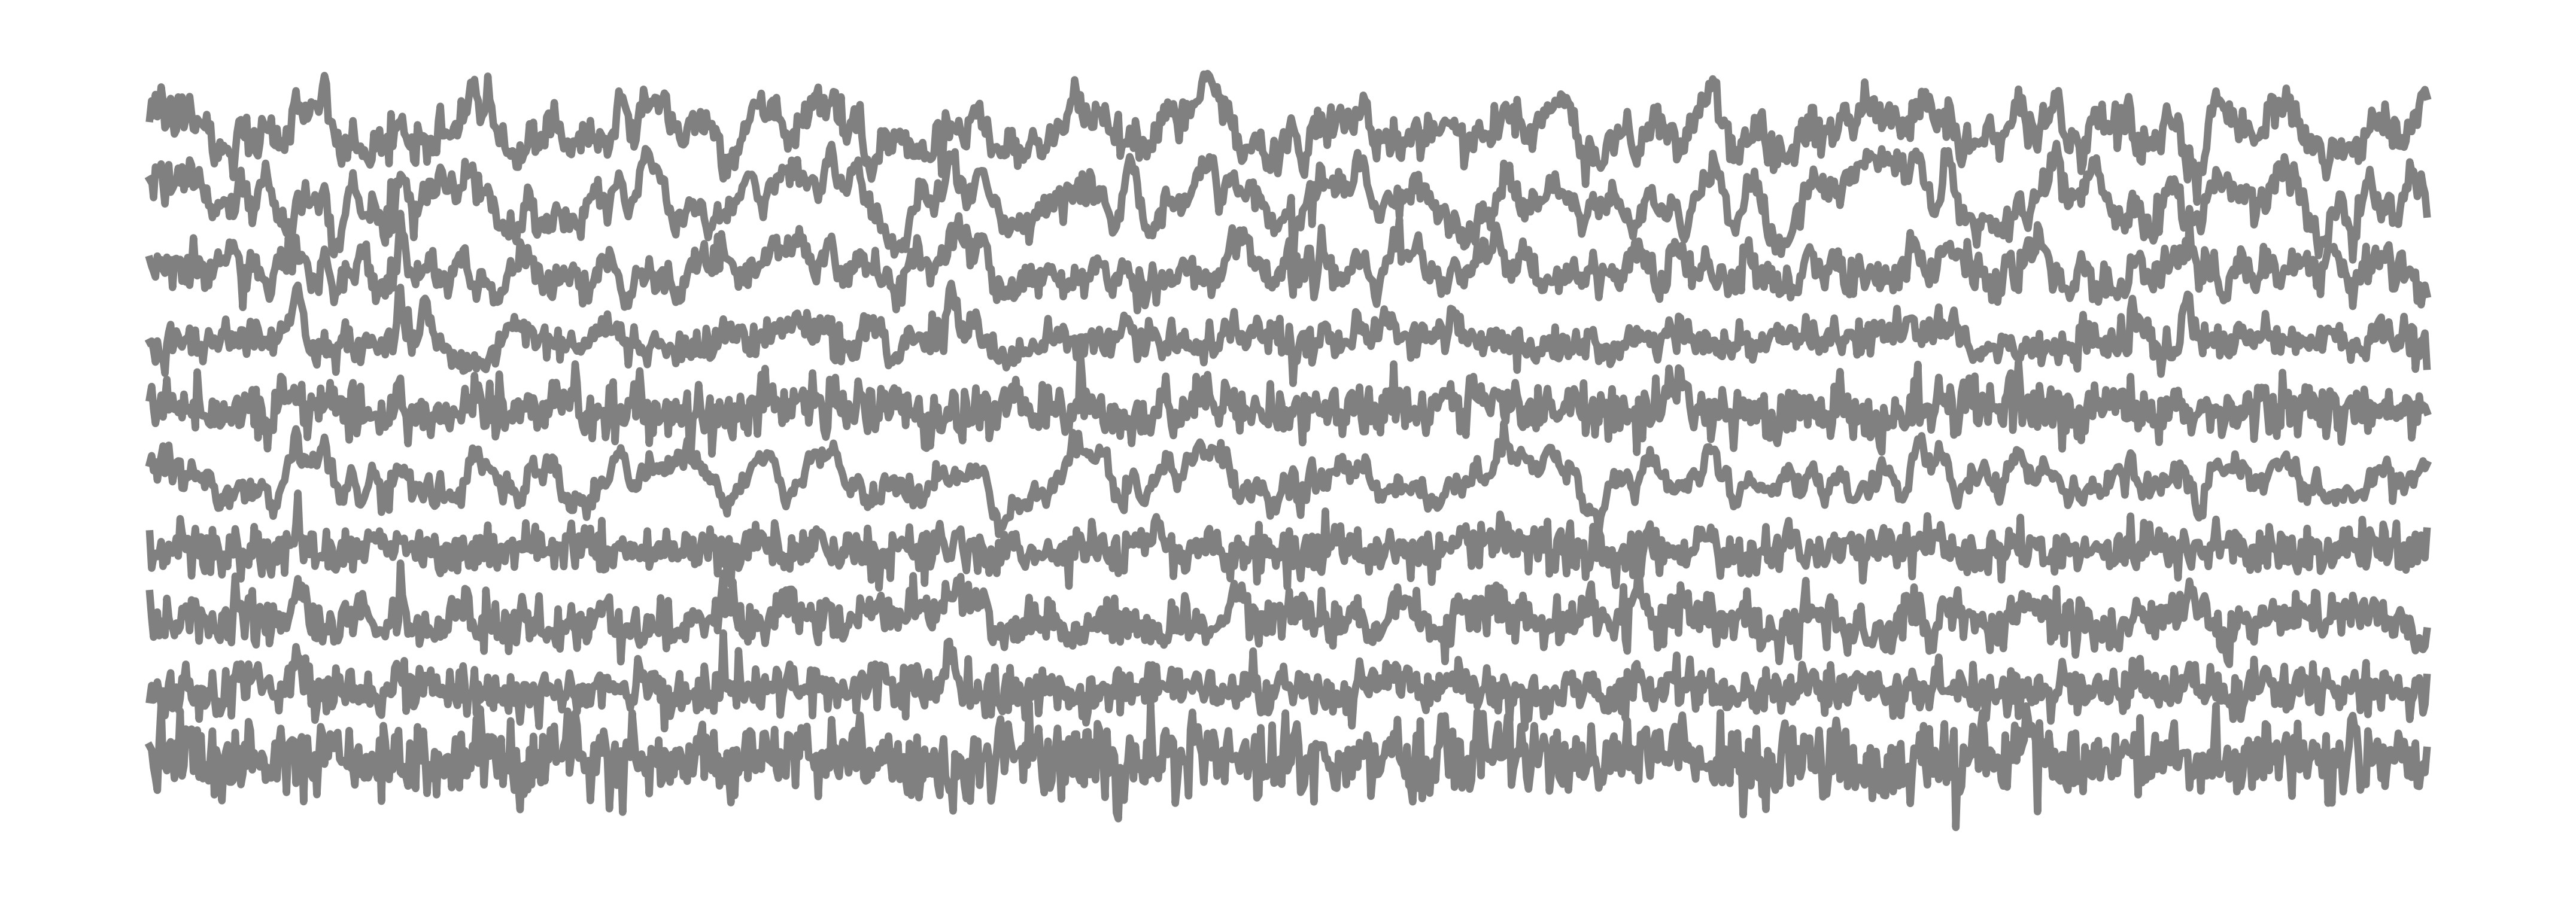

In [8]:
# load and z-score empirical bold
emp_bold = np.load(os.path.join(
        cubnm_paper.config.DATA_DIR, 'hcp', 
        'bold', '912447', 'REST1_LR',
        'ctx_parc-schaefer-100_desc-bold.npz'
    ))['arr_0']
emp_bold = scipy.stats.zscore(emp_bold, axis=1)
emp_bold = pd.DataFrame(emp_bold)

# plot 10 regions
fig, ax = plt.subplots(figsize=(9, 3))
for i in range(0, 100, 10):
    ax.plot(
        emp_bold.columns,
        0.125 * i + (emp_bold.iloc[i, :] / emp_bold.iloc[i, :].max()),
        color="grey",
    )
ax.axis('off')

Calculate empirical FC and FCD:

In [11]:
emp_fc = cubnm.utils.calculate_fc(emp_bold.values, exc_interhemispheric=True, return_tril=False)
emp_fcd = cubnm.utils.calculate_fcd(
    emp_bold.values, 
    window_size=cmaes.problem.sim_group.window_size_TRs, 
    window_step=cmaes.problem.sim_group.window_step_TRs, 
    exc_interhemispheric=True,
    return_tril=False
)

Plot empirical and simulated FC:

[]

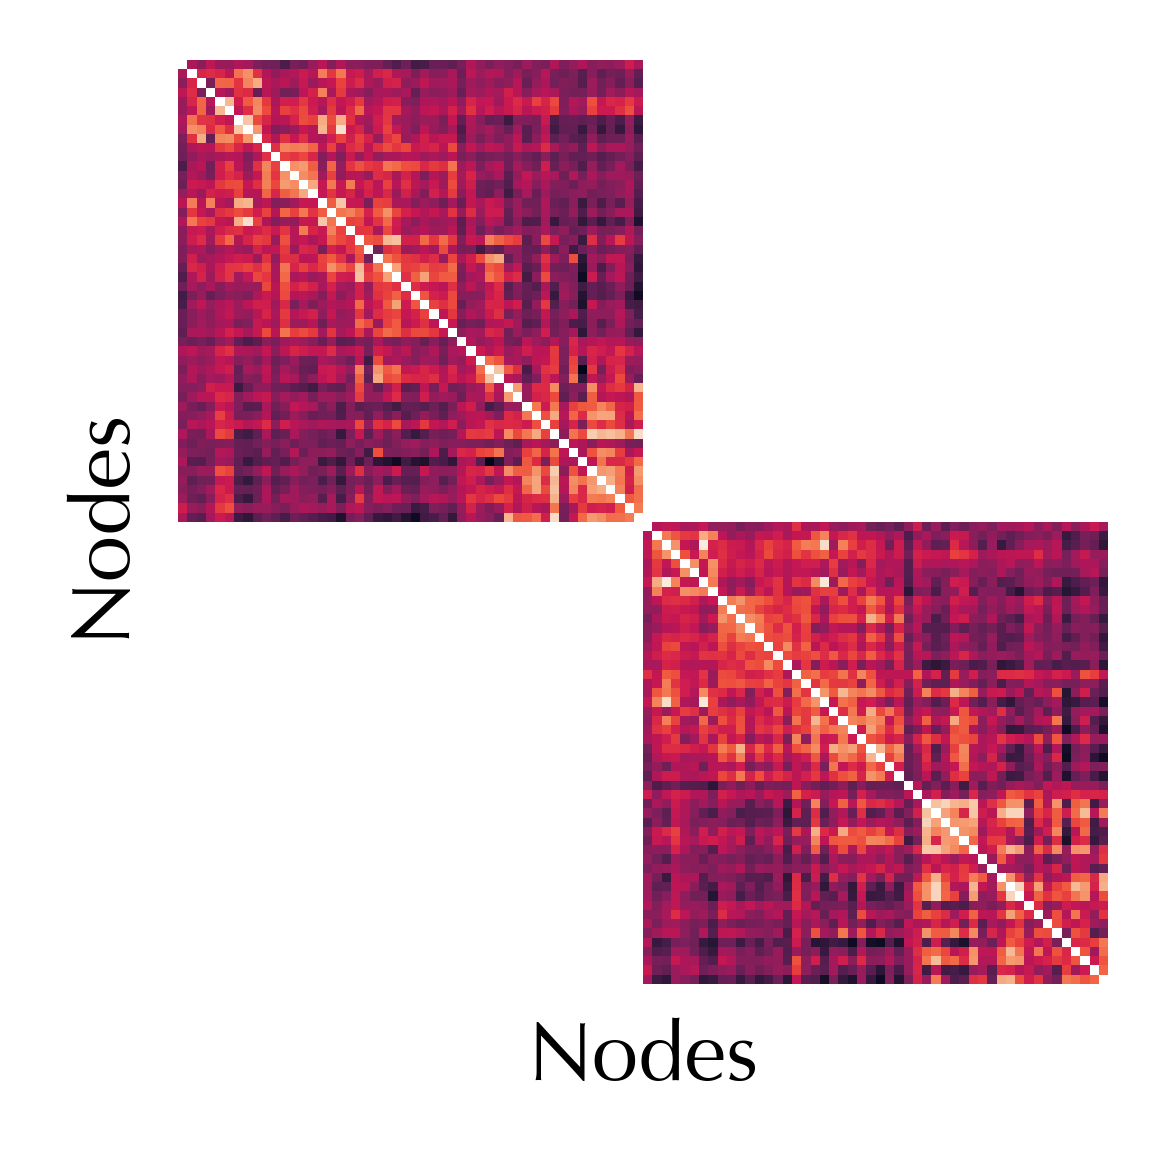

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))
emp_fc[np.diag_indices_from(emp_fc)] = np.NaN
sns.heatmap(
    emp_fc, cbar=False, ax=ax,
)
ax.set_xlabel('Nodes')
ax.set_ylabel('Nodes')
ax.set_xticks([])
ax.set_yticks([])

[]

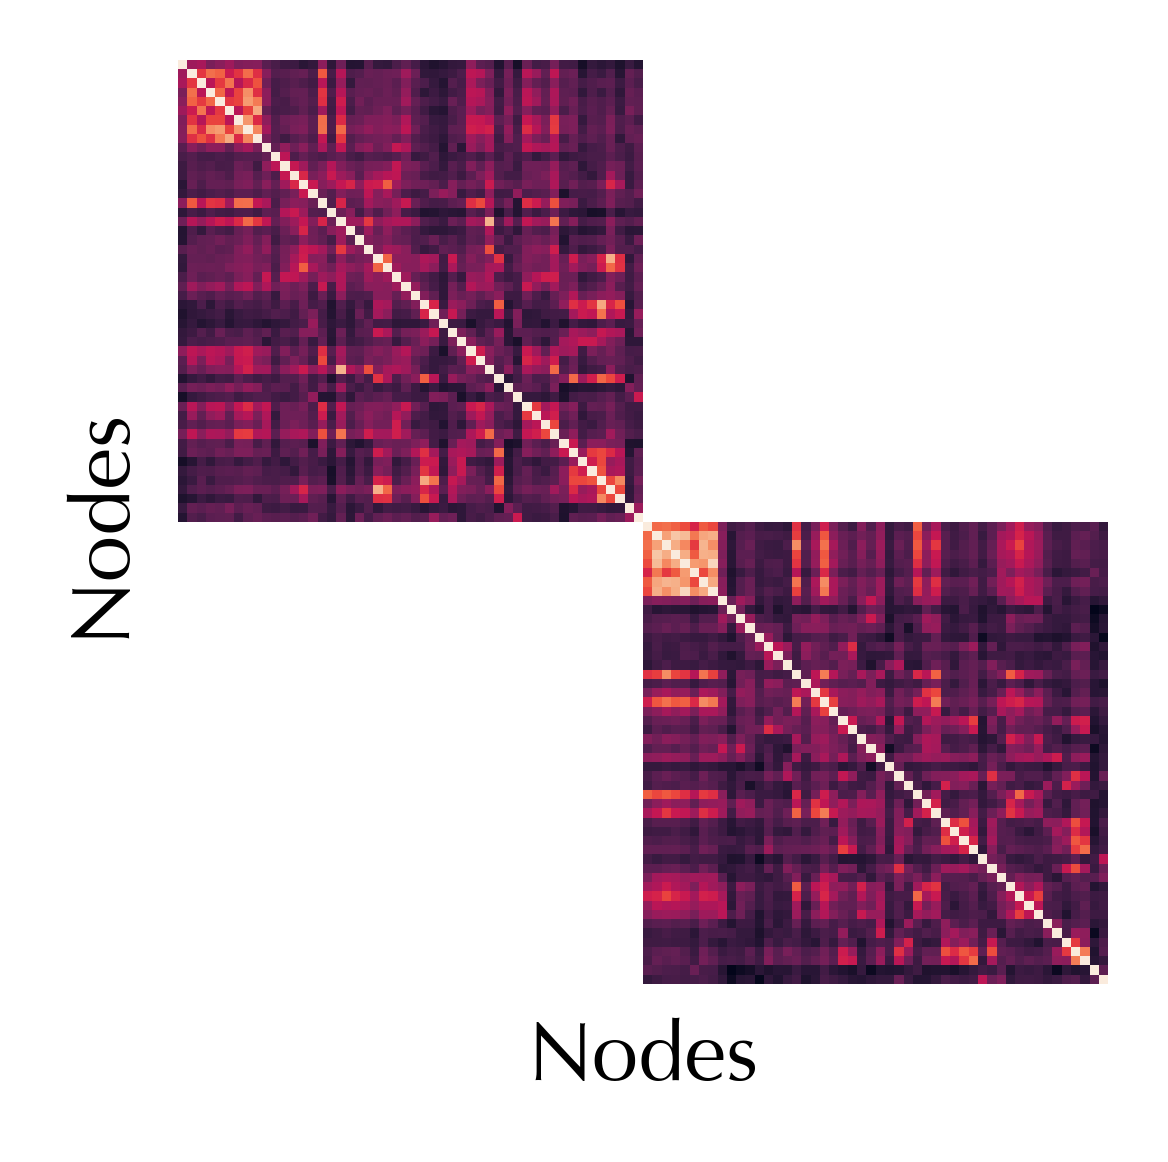

In [13]:
sim_fc = sim_group.get_sim_fc(0)

# plot it
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(
    sim_fc, cbar=False, ax=ax,
)
ax.set_xlabel('Nodes')
ax.set_ylabel('Nodes')
ax.set_xticks([])
ax.set_yticks([])

Plot empirical and simulated FCD:

[]

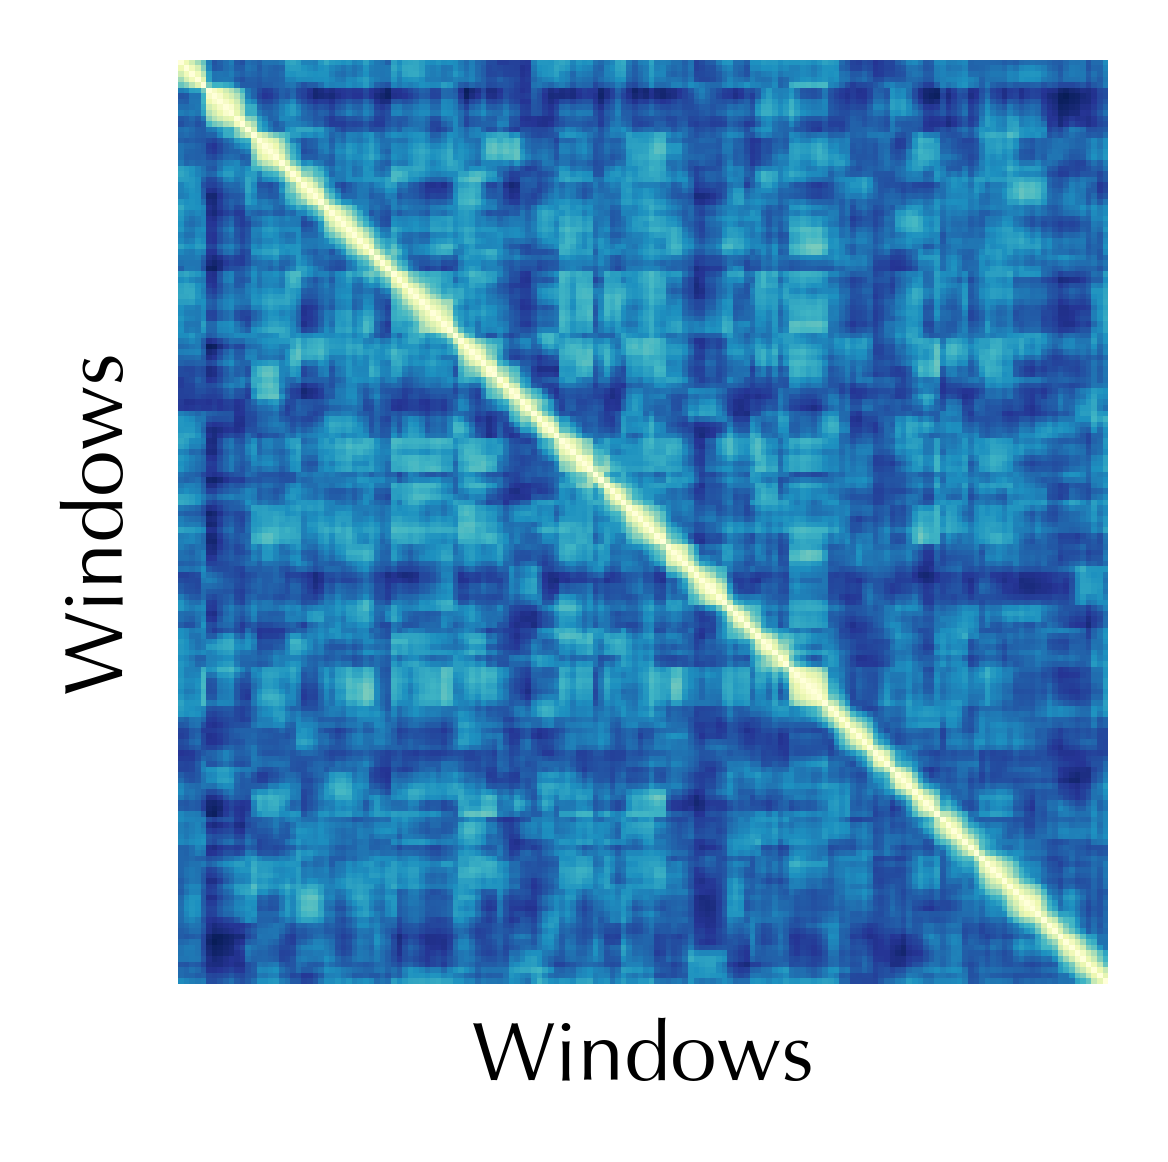

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(
    emp_fcd, cbar=False, ax=ax, vmin=emp_fcd.min(), vmax=emp_fcd.max(), cmap="YlGnBu_r"
)
ax.set_xlabel('Windows')
ax.set_ylabel('Windows')
ax.set_xticks([])
ax.set_yticks([])

[]

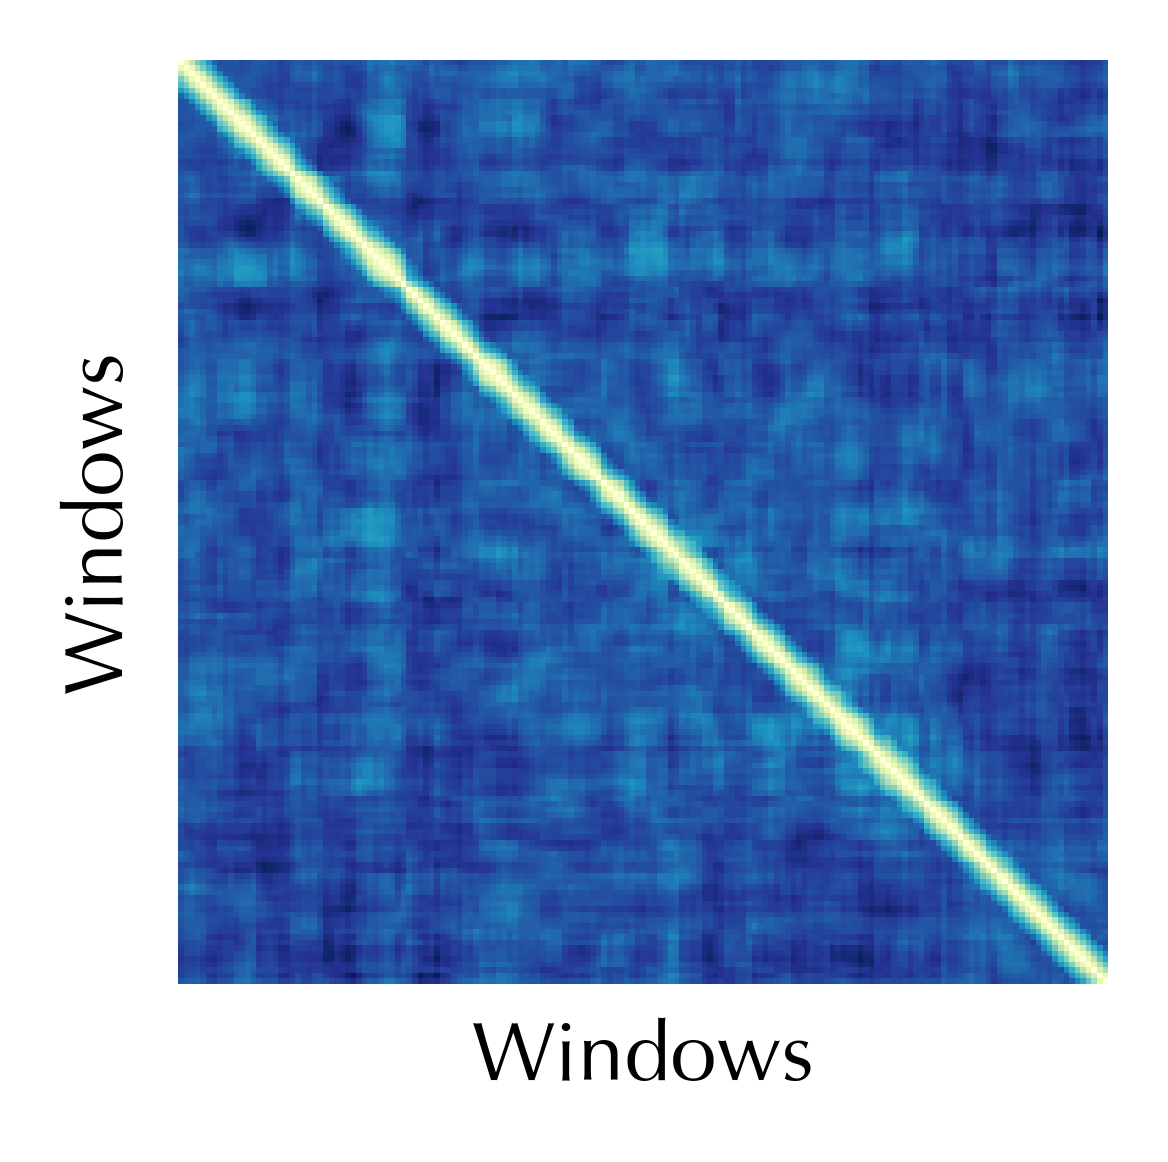

In [15]:
sim_fcd = sim_group.get_sim_fcd(0)

fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(
    sim_fcd, cbar=False, ax=ax, vmin=sim_fcd.min(), vmax=sim_fcd.max(), cmap="YlGnBu_r"
)
ax.set_xlabel('Windows')
ax.set_ylabel('Windows')
ax.set_xticks([])
ax.set_yticks([])

Cost and cost components of the sample:

Text(-76.72916666666669, 0.5, 'Simulations')

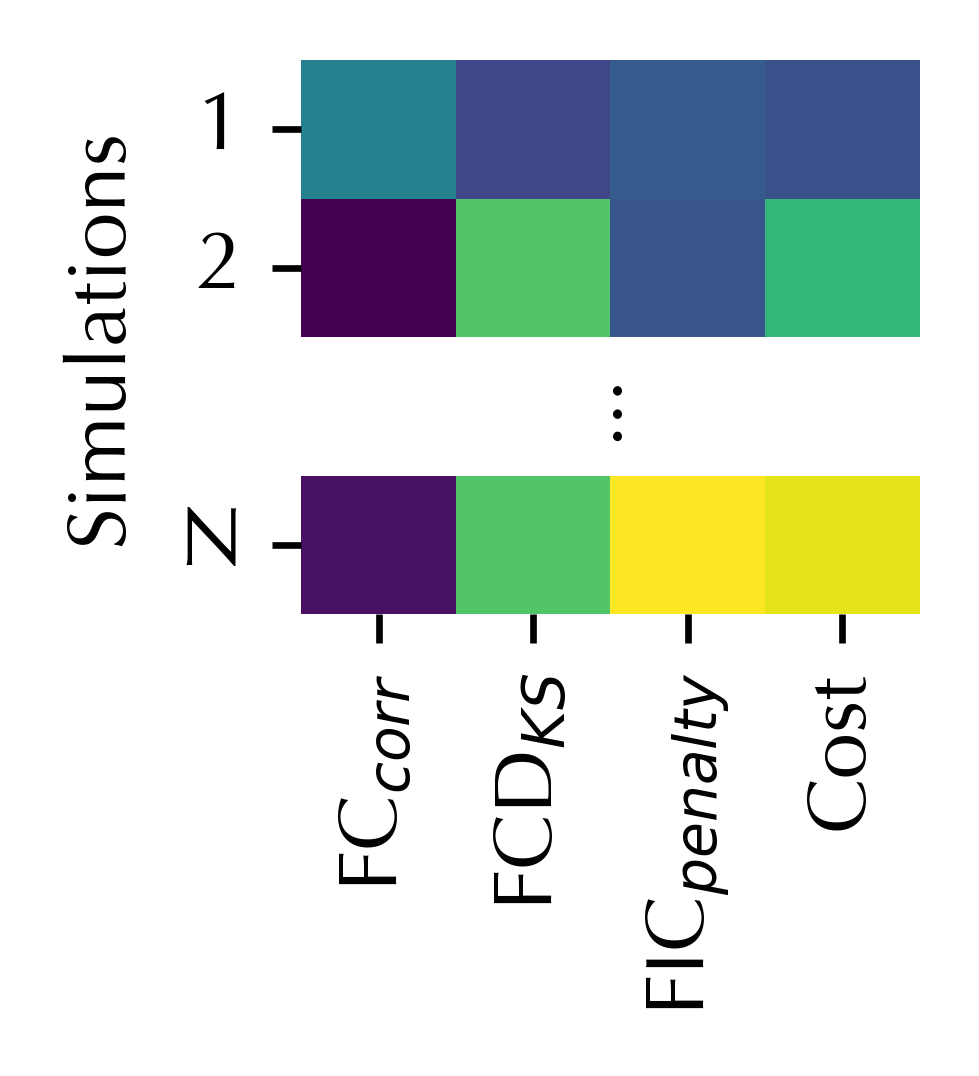

In [25]:
fig, ax = plt.subplots(figsize=(1.33, 1.2))
# zscore each column across the history, then index to the sample
plot_data = hist.loc[:, ['+fc_corr', '-fcd_ks', '-fic_penalty', 'cost']].abs().apply(scipy.stats.zscore).loc[sample.index]
plot_data.iloc[-2, :] = np.NaN
sns.heatmap(plot_data, cbar=False, ax=ax, cmap='viridis')
ax.set_xticklabels([r'FC$_{corr}$', r'FCD$_{KS}$', r'FIC$_{penalty}$', 'Cost'])
ax.set_yticks(np.array([0, 1, 3])+0.5)
yticklabels = ['1', '2', 'N']
ax.set_yticklabels(yticklabels, rotation=0)
ax.text(
    1.9, 2.5, '...',
    fontsize=10, color='black', rotation='vertical', ha='center', va='center',
)
ax.set_ylabel('Simulations')